In [1]:
%pylab inline
import time
import os 
image_dir = os.getcwd() + '/Images/'
model_dir = os.getcwd() + '/Models/'

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from collections import OrderedDict


Populating the interactive namespace from numpy and matplotlib


In [2]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [46]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        #print(G)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        #print(input,target)
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [47]:
# pre and post processing for images
img_size = 256 
prep = transforms.Compose([transforms.RandomCrop(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [48]:
#get network
vgg = VGG()
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

In [134]:
#load images, ordered as [style_image, content_image]
img_dirs = [image_dir, image_dir]
img_names = ['geo1.png', 'color_blue.png']
imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
imgs_torch = [prep(img) for img in imgs]
if torch.cuda.is_available():
    imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
else:
    imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
style_image, content_image = imgs_torch

# opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True) #random init
opt_img = Variable(content_image.data.clone(), requires_grad=True)

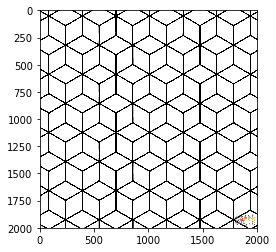

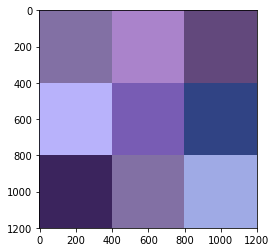

In [135]:
#display images
for img in imgs:
    imshow(img);show()

In [136]:
#define layers, loss functions, weights and compute optimization targets
style_layers = ['r11','r21','r31','r41', 'r51'] 
content_layers = ['r42']
loss_layers = style_layers + content_layers
loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
if torch.cuda.is_available():
    loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
    
#these are good weights settings:
style_weights = [250,240,203,202,210]
#style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
content_weights = [1e0]
weights = style_weights + content_weights

#compute optimization targets
style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
content_targets = [A.detach() for A in vgg(content_image, content_layers)]
targets = style_targets + content_targets

In [137]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class convBlock(torch.nn.Module):
    def __init__(self):
        super(convBlock, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=1, stride=1, padding=0)
    
    def forward(self, X):
        h = F.relu(self.conv1(X))
        h = F.relu(self.conv2(h))
        h = self.conv3(h)
        
        return h

class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        reflection_padding = int(np.floor(kernel_size / 2))
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = self.upsample_layer(x_in)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out


class Convup(torch.nn.Module):
    def __init__(self):
        super(Convup, self).__init__()
        
        z1 = np.random.random((3,64,64))
        z1 = torch.from_numpy(z1).unsqueeze(0)
        z1 = z1.float()
        z1 = Variable(z1)

        z2 = np.random.random((3,128,128))
        z2 = torch.from_numpy(z2).unsqueeze(0)
        z2 = z2.float()
        z2 = Variable(z2)

        z3 = np.random.random((3,256,256))
        z3 = torch.from_numpy(z3).unsqueeze(0)
        z3 = z3.float()
        z3 = Variable(z3)
        
        self.z1 = z1
        self.conv1 = convBlock()
        
        self.z2 = z2
        self.conv2 = convBlock()
        
        self.z3 = z3
        self.conv3 = convBlock()
        
        self.conv12a = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.conv12b = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.conv12c = nn.Conv2d(16, 16, kernel_size=1, stride=1, padding=0)
        
        self.conv123a = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1)
        self.conv123b = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1)
        self.conv123c = nn.Conv2d(24, 24, kernel_size=1, stride=1, padding=0)
        
        self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2)
        self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2)
        self.upsample3 = UpsampleConvLayer(24, 3,kernel_size=1, stride=1)
        
    def forward(self, X):
        h=self.conv1(self.z1)
        h1 = F.relu(self.conv1(self.z1))
       
        h2 = F.relu(self.conv2(self.z2))
        
        h3 = F.relu(self.conv3(self.z3))
        
        h1 = F.relu(self.upsample1(h1))
        h12 = torch.cat((h1,h2),1)
        
        h12 = F.relu(self.conv12a(h12))
        h12 = F.relu(self.conv12b(h12))
        h12 = F.relu(self.conv12c(h12))
        
        h12 = F.relu(self.upsample2(h12))
        h123 = torch.cat((h12,h3),1)
        
        h123 = F.relu(self.conv123a(h123))
        h123 = F.relu(self.conv123b(h123))
        h123 = F.relu(self.conv123c(h123))
        
        h123 = F.relu(self.upsample3(h123))
        
        h = h123+X
        
        return h

In [138]:
net=Convup()
output = net(opt_img)

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:135: UserWarning: nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingNearest2d is deprecated. Use nn.Upsample instead.")


Iteration: 50, loss: 18858215735296.000000
Iteration: 100, loss: 6857626222592.000000
Iteration: 150, loss: 4510000873472.000000
Iteration: 200, loss: 3429397692416.000000
Iteration: 250, loss: 2799473786880.000000
Iteration: 300, loss: 2417146986496.000000
Iteration: 350, loss: 2128070967296.000000
Iteration: 400, loss: 1900939444224.000000
Iteration: 450, loss: 1703864434688.000000
Iteration: 500, loss: 1528223367168.000000


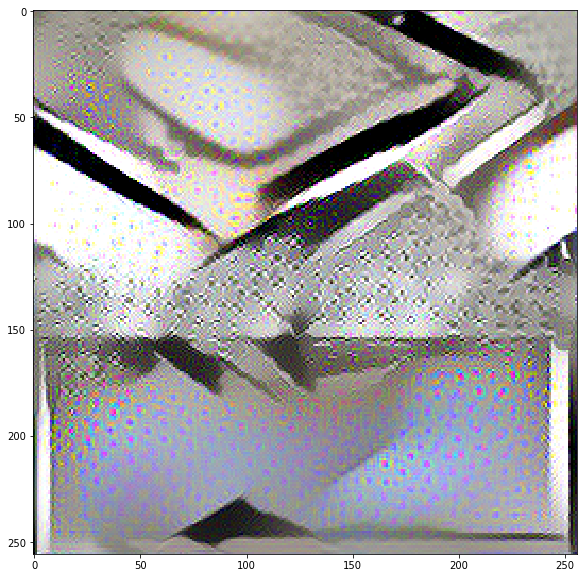

In [139]:

max_iter = 500
show_iter = 50
optimizer = optim.LBFGS([opt_img]);
n_iter=[0]

net=Convup()

while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        output = net(opt_img)
        out = vgg(output, loss_layers)
        layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.data[0]))
#             print([loss_layers[li] + ': ' +  str(l.data[0]) for li,l in enumerate(layer_losses)]) #loss of each layer
        return loss
    
    optimizer.step(closure)
    
#display result
out_img = postp(opt_img.data[0].cpu().squeeze())
imshow(out_img)
gcf().set_size_inches(10,10)